In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import joblib
from tqdm import tqdm
from helper import calc_local_roughness
from dask_ml.wrappers import ParallelPostFit, Incremental

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from scipy.ndimage import gaussian_filter
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict, GridSearchCV, RandomizedSearchCV

from dask.distributed import Client, LocalCluster
import dask.array as da

cluster = LocalCluster(local_directory='/projekt_agmwend/home_rad/Joshua/dask-worker-space', memory_limit='32GB', n_workers=16, threads_per_worker=1)
client = Client(cluster)



test_ds_v4 = xr.open_zarr('/home/jomueller/MasterArbeit/ml_classification/test_ds.zarr')


def train_random_forest(X, y, n_jobs=1, sigma=2.5, X_rgh=None):

    # Reshape the data to 2D
    X = X.reshape(-1, 5)
    y = y.reshape(-1)

    print('Inital unique labels:', np.unique(y))
    
    print('X shape:', X.shape)
    print('y shape:', y.shape)

    if X_rgh is not None:
        r1, r2, r3 = X_rgh
        r1 = r1.flatten()
        r2 = r2.flatten()
        r3 = r3.flatten()

    mask = (y !=0 ) & ~np.isnan(y) & np.all(np.isfinite(X), axis=1) & (y != 3)

    # Remove pixels with label 0
    X_filtered = X[mask, :] 
    y_filtered = y[mask]
    r1 = r1[mask]
    r2 = r2[mask]
    r3 = r3[mask]

    dx1 = X_filtered[:, 1] - X_filtered[:, 4]
    dx2 = X_filtered[:, 2] - X_filtered[:, 4]
    dx3 = X_filtered[:, 3] - X_filtered[:, 4]

    X_filtered = np.stack((X_filtered[:, 0], dx1, dx2, dx3, r1, r2, r3), axis=1)

    #X_filtered = np.stack((X_filtered[:, 0], r2, r3), axis=1)


    print('Unique labels:', np.unique(y_filtered))

    N = len(y_filtered)

    print(len(y_filtered[y_filtered==1]) / N, 'Open Water')
    print(len(y_filtered[y_filtered==2]) / N, 'Dark Nilas')
    print(len(y_filtered[y_filtered==3]) / N, 'Bare Sea Ice')
    print(len(y_filtered[y_filtered==4]) / N, 'Snow-covered Sea Ice')


    y_filtered[y_filtered==1] = 1
    y_filtered[y_filtered==2] = 2
    y_filtered[y_filtered==3] = 3
    y_filtered[y_filtered==4] = 4


    model = RandomForestClassifier(random_state=42, n_jobs=n_jobs,
            n_estimators=50, max_depth=50, min_samples_split=2, min_samples_leaf=1, bootstrap=True,
            criterion='gini', max_features='sqrt',)
    
    #logo = LeaveOneGroupOut()

    scoring = 'accuracy'
    model = ParallelPostFit(model)
    #model = Incremental(model, scoring=scoring)

    with joblib.parallel_backend('dask'):
        model.fit(X_filtered, y_filtered)
    
    return model, #y_pred, metrics

test_ds_v4 = calc_local_roughness(test_ds_v4)

X, y = test_ds_v4['BT_2D'].values, test_ds_v4['label'].values
X_add = test_ds_v4['sur_rgh'].values, test_ds_v4['neighbor_mean'].values, test_ds_v4['neighbor_std'].values

base_path = f"/projekt_agmwend/data/HALO-AC3/05_VELOX_Tools/ml_sea-ice-classification/models/rf"
model_path = os.path.join('/projekt_agmwend/data/HALO-AC3/05_VELOX_Tools/ml_sea-ice-classification/models', 'final_model_3_class_no_bare.joblib')

clf = train_random_forest(X, y, n_jobs=1, X_rgh=X_add)


/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46381 instead
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 71.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Inital unique labels: [0 1 2 3 4]
X shape: (18672810, 5)
y shape: (18672810,)
Unique labels: [1 2 4]
0.08479244103560386 Open Water
0.1480262401904756 Dark Nilas
0.0 Bare Sea Ice
0.7671813187739205 Snow-covered Sea Ice


In [3]:
data = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-03-28_v_0.1.nc', chunks={'time' : 250, 'x' : 250, 'y' : 250, 'band' : 5})#.isel(time=slice(0, 1000)).persist()

X0 = data['BT_2D'].isel(band=0)
X1 = data['BT_2D'].isel(band=1) - data['BT_2D'].isel(band=4)
X2 = data['BT_2D'].isel(band=2) - data['BT_2D'].isel(band=4)
X3 = data['BT_2D'].isel(band=3) - data['BT_2D'].isel(band=4)
X4 = data['sur_rgh']
X5 = data['neighbor_mean']
X6 = data['neighbor_std']

XX = da.stack((X0, X1, X2, X3, X4, X5, X6), axis=0)
#XX = da.stack((X0, X4, X5), axis=0)

X_shape = XX.shape  
target_shape = (data.time.size, data.x.size, data.y.size)

print(X_shape, target_shape)    

XX = XX.reshape(7, -1).T
#pred = XX.map_partitions(
#    dask_predict,
#    model=clf_fut,
#    meta=np.array([1]),
#)

da.rechunk(XX, chunks={0 : 10_000_000, 1 : 7})
pred = clf[0].predict(XX)

pred_2d = pred.reshape(target_shape)
pred_2d = xr.DataArray(pred_2d, coords={'time': data.time, 'x': data.x, 'y': data.y}, dims=['time', 'x', 'y'])


(7, 6166, 635, 507) (6166, 635, 507)


In [4]:
import dask
#scattered_model = client.scatter(clf, broadcast=True)
scattered_model = dask.delayed(clf[0])

def dask_predict(part, model):
    return model.predict(part)

preds = XX.map_blocks(
    dask_predict,
    model=scattered_model,
    dtype="int",
    drop_axis=1,
    meta=np.array([1]),
)

pred_2d = preds.reshape(target_shape)
pred_2d = xr.DataArray(pred_2d, coords={'time': data.time, 'x': data.x, 'y': data.y}, dims=['time', 'x', 'y'])


pred_2d.to_netcdf('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-03-28_v_0.1_pred.nc', engine='h5netcdf', mode='w')

/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 2.94 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [6]:
pred_2d_at_disk = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-03-28_v_0.1_pred.nc', engine='h5netcdf', chunks={'time' : 250, 'x' : 250, 'y' : 250})

In [10]:
pred_2d_at_disk = pred_2d_at_disk.rename({'reshape-8d039a12c1c74ebe52058a6b54f77568' : 'label'})


In [12]:
pred_2d_at_disk

<xarray.Dataset>
Dimensions:  (time: 6166, x: 635, y: 507)
Coordinates:
  * time     (time) datetime64[ns] 2022-03-28T10:26:30 ... 2022-03-28T14:27:39
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 626 627 628 629 630 631 632 633 634
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 498 499 500 501 502 503 504 505 506
Data variables:
    label    (time, x, y) int64 dask.array<chunksize=(250, 250, 250), meta=np.ndarray>

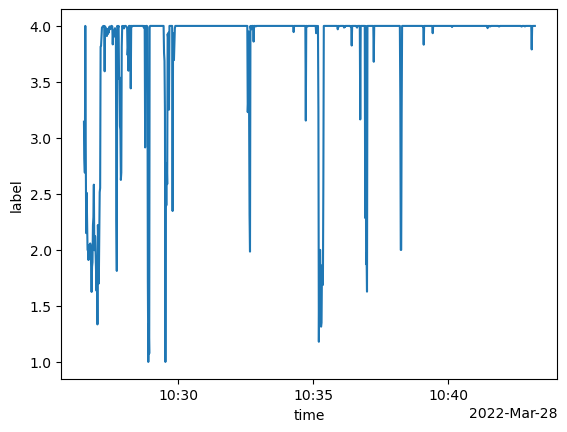

In [17]:
nadir_class = pred_2d_at_disk.label.isel(x=slice(310, 330), y=slice(240, 260)).mean(dim=['x', 'y'])
nadir_class.isel(time=slice(0, 1000)).plot()

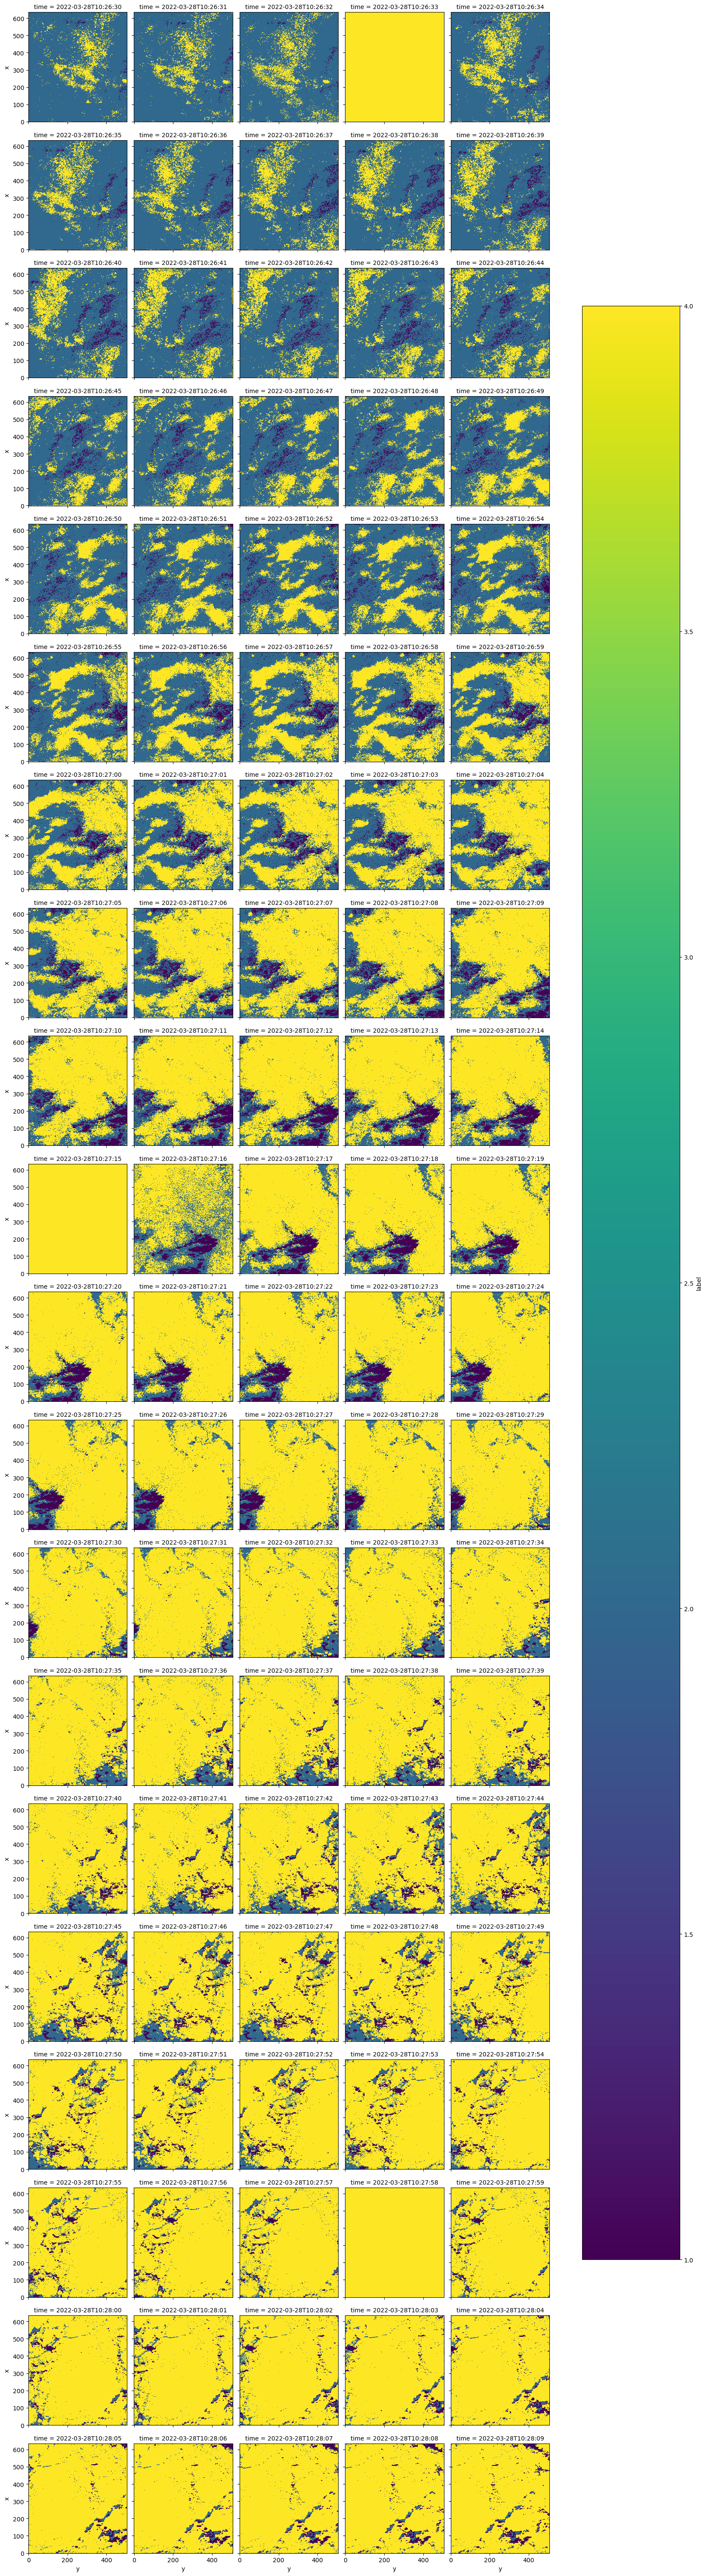

In [15]:
pred_2d_at_disk.label.isel(time=slice(0, 100)).plot(col_wrap=5, col='time', cmap='viridis', robust=True)